In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


### Predicting Future Energy Consumption using XGBoost


AEP : american electric power
- estimated energy consumption in Megawatts (MW)

## Objective :  
Our goal in this project is to forecast hourly energy consumption based on past historical records using machine learning technique

In [101]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)


In [102]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [103]:
df.shape

(145366, 1)

In [104]:
df.isnull().sum()

PJME_MW    0
dtype: int64

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


## EDA

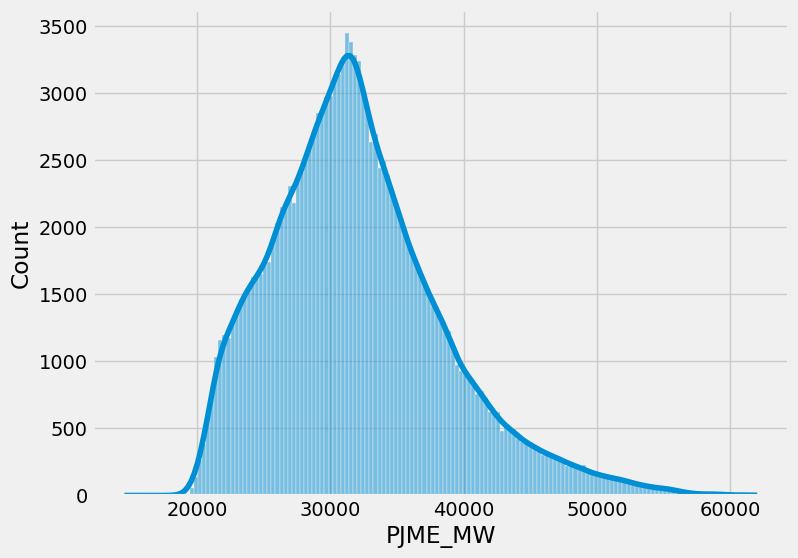

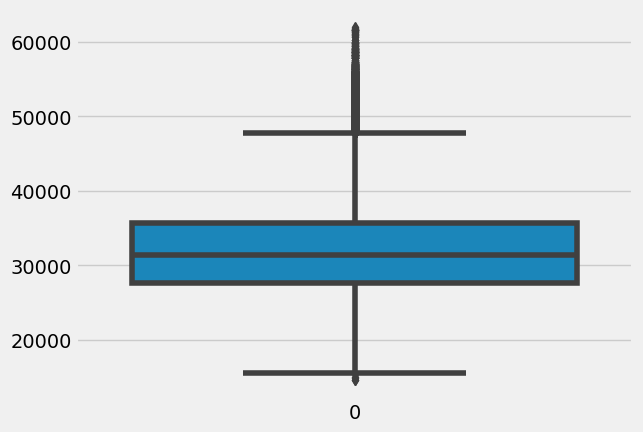

In [106]:
for col in df.columns:
    plt.figure(figsize=(8,6))
    sns.histplot(x = df[col], kde = True)
    plt.show()
    sns.boxplot(df[col])
    plt.show()

## Insights
- The energy consumption slightly right skewed but almost normally distrubuted

- 28k to 35k range spread and median lies around 31k

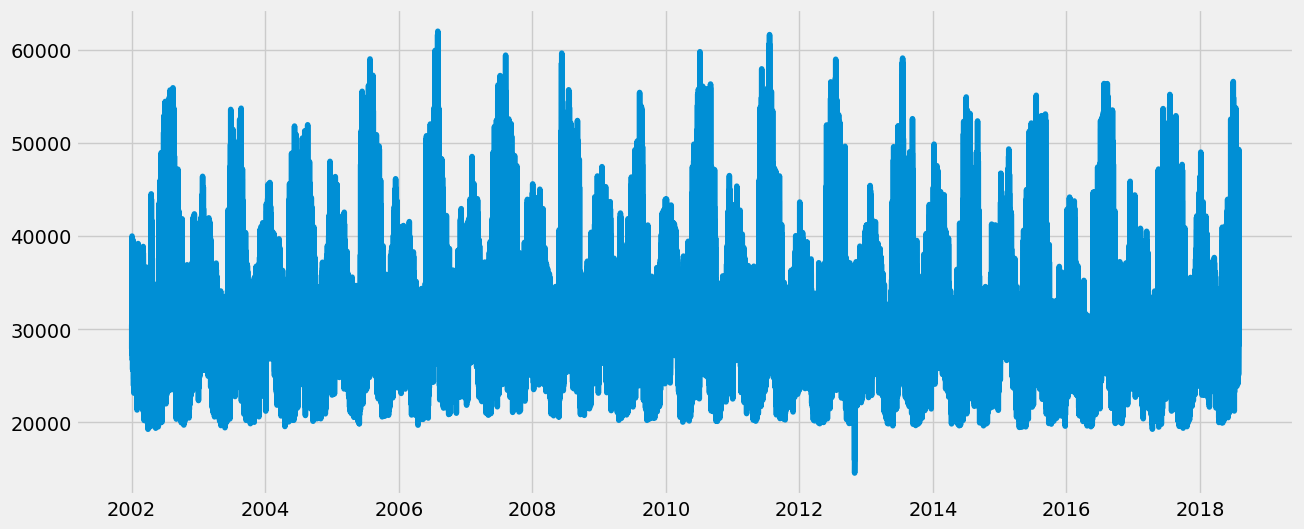

In [107]:
# Consumption trend
plt.figure(figsize=(14,6))
plt.plot(df.index,df['PJME_MW'])
plt.show()

## Train test Split

we would train our model with data till 2016 and rest from 2016 to 2018 will be for validating our model accuracy

In [108]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

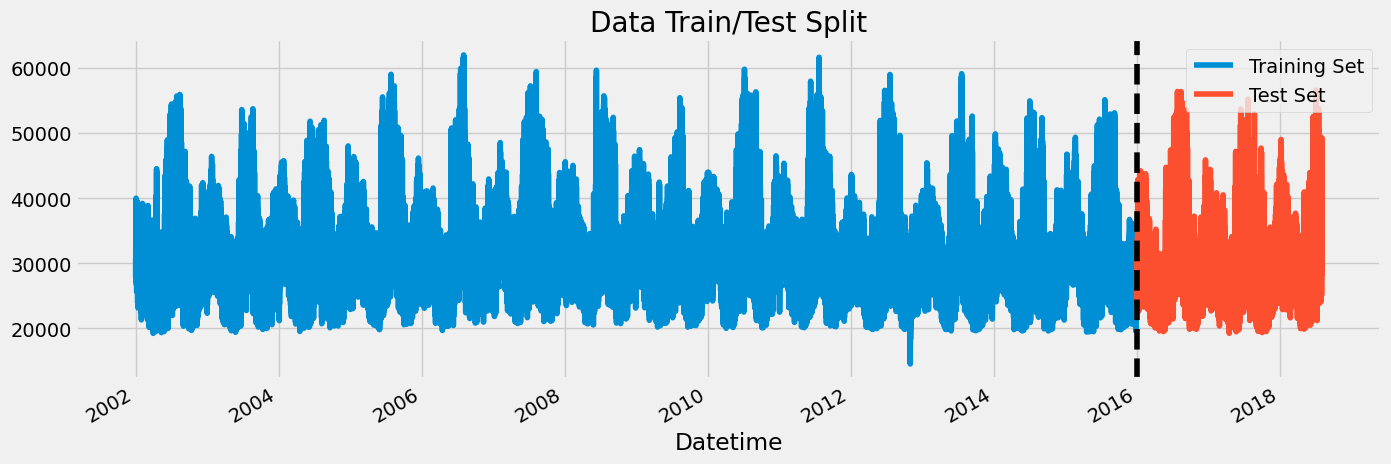

In [109]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [110]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Visualize

In [111]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [112]:
attr = ['hour', 'dayofweek', 'quarter', 'month', 'year']

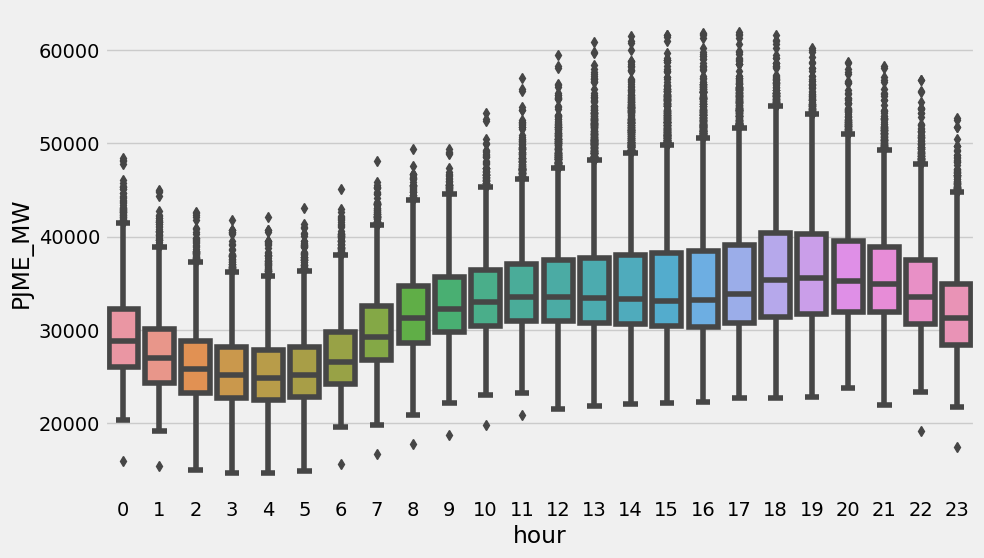

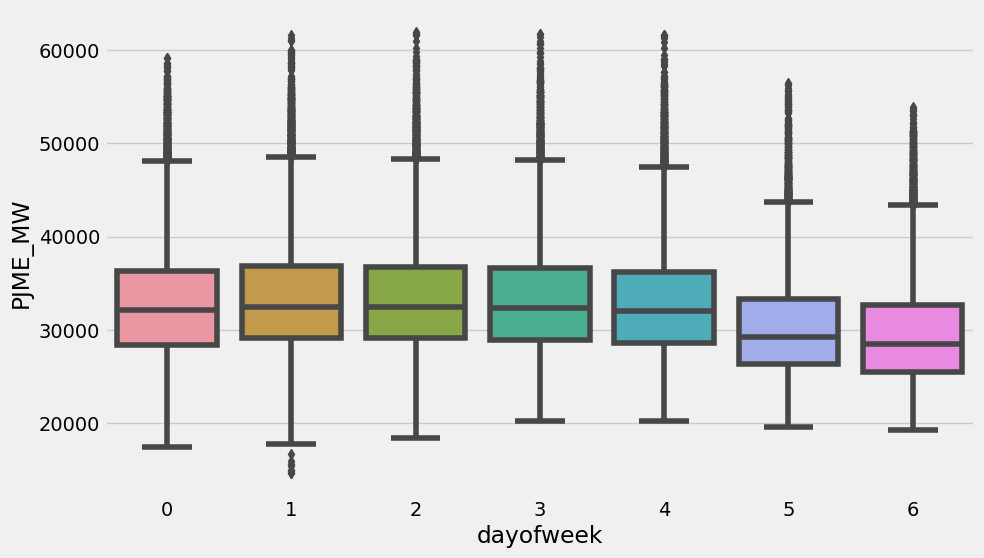

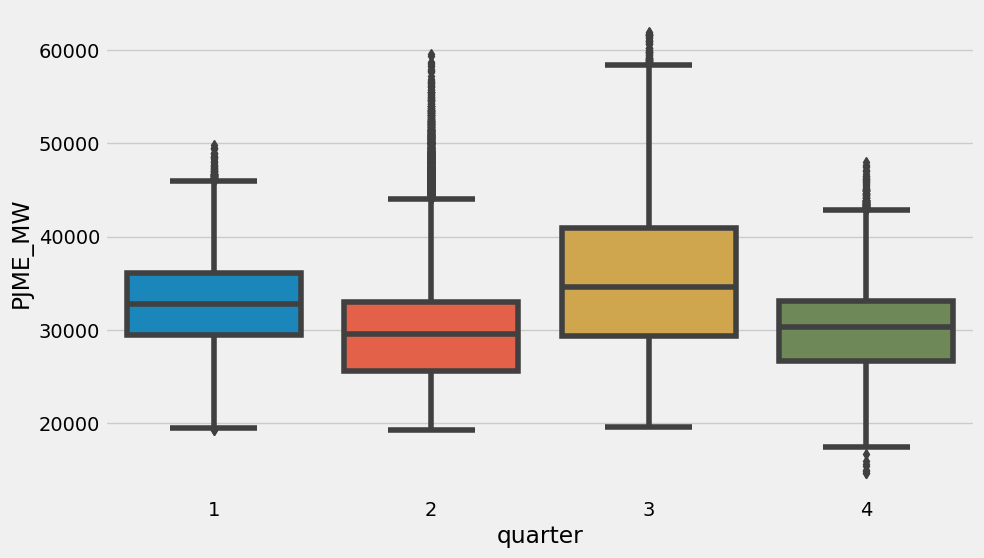

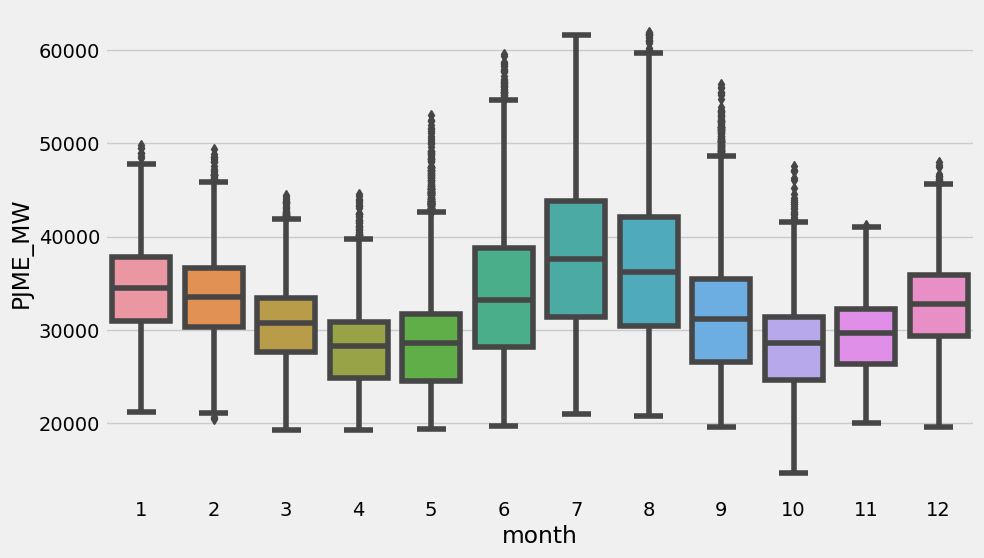

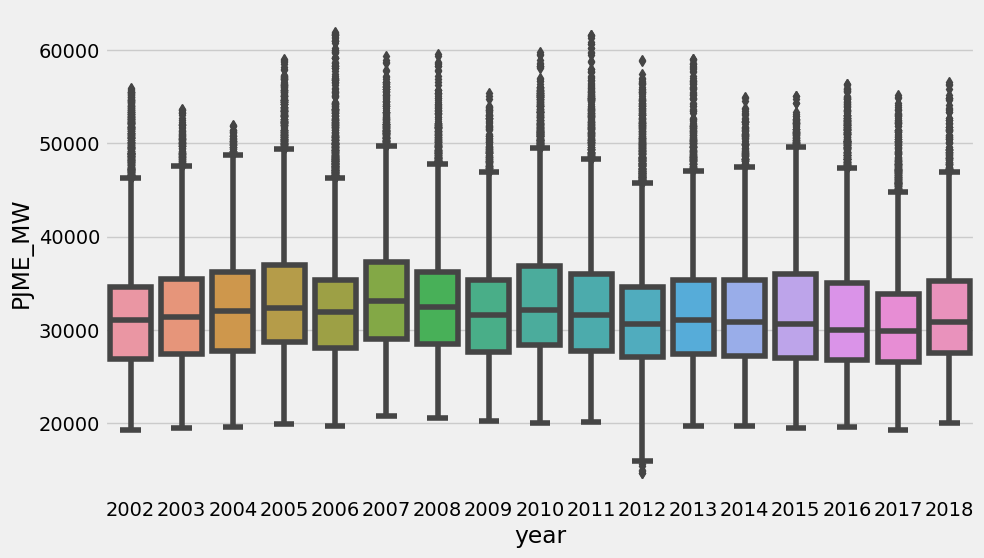

In [113]:
for col in attr:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x=df[col], y='PJME_MW')
    ax.set_title(col)
    plt.show()

## Insights
- Time of the day  - 6pm
- Day of the week - Day 1
- Quarter - 3rd Quarter spread is more
- Month - July has high spread and higher mean


## Model Creation

In [114]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [115]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32567.35644	validation_1-rmse:31498.01001
[100]	validation_0-rmse:12577.27614	validation_1-rmse:11602.63131
[200]	validation_0-rmse:5849.64279	validation_1-rmse:5280.06298
[300]	validation_0-rmse:3949.71550	validation_1-rmse:4038.64968
[400]	validation_0-rmse:3477.38016	validation_1-rmse:3941.41691
[500]	validation_0-rmse:3320.84887	validation_1-rmse:3929.37353
[579]	validation_0-rmse:3255.29937	validation_1-rmse:3927.78627


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature importance

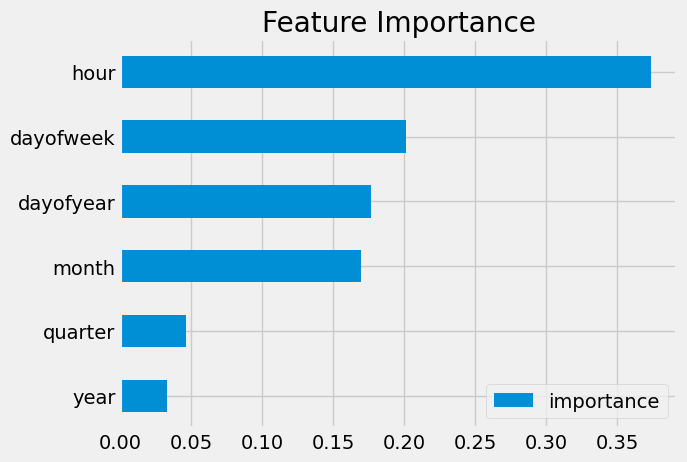

In [116]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecasting on test set

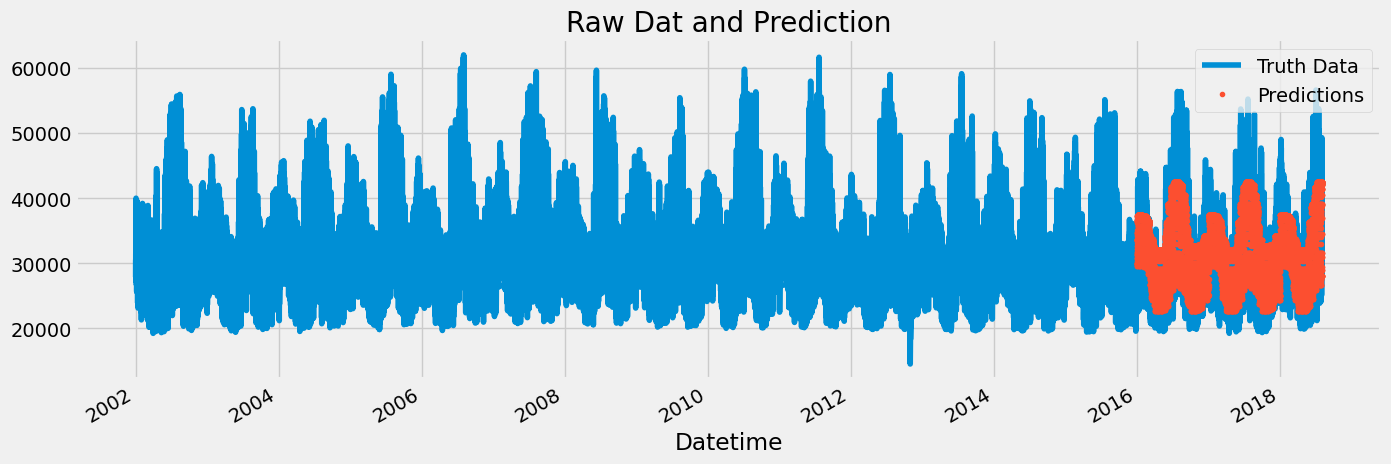

In [117]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

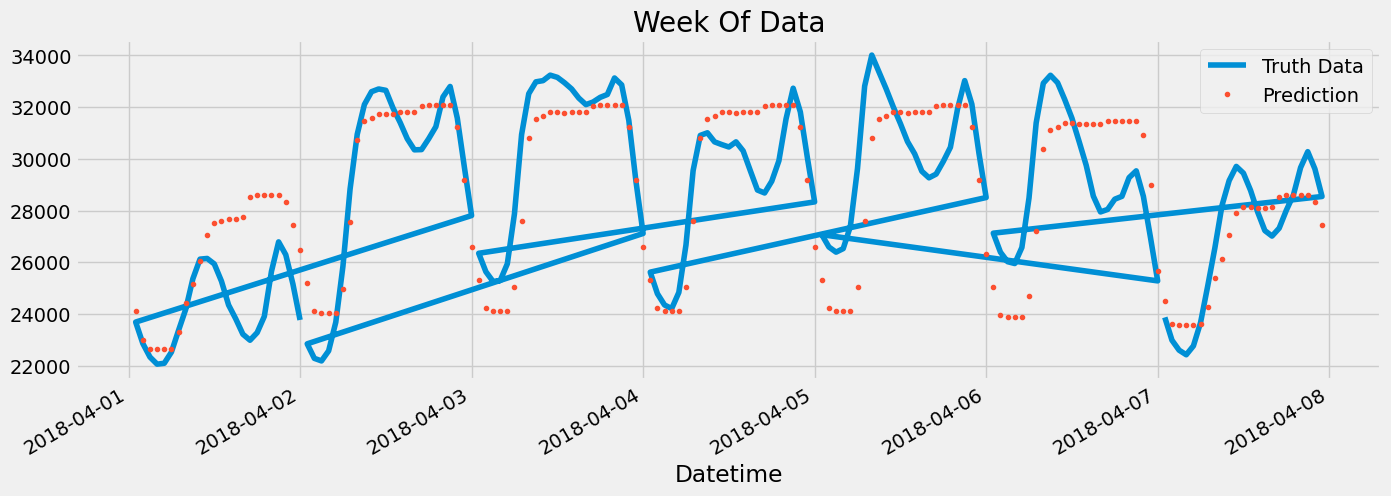

In [118]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## RMSE

In [119]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3923.85


## Worst and Best predicted days

In [120]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    11719.034668
2016-08-14    11487.507406
2017-12-31    10887.096273
2016-09-09    10524.269694
2018-01-06    10493.821126
2016-09-10    10354.283122
2018-01-07     9608.625407
2017-12-28     9498.369548
2016-08-12     9434.913981
2017-12-29     9168.655599
Name: error, dtype: float64